In [100]:
import torch
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.optim as optim
from tqdm import tqdm

In [101]:
def get_path(txt_path, dataset='train'):
    train_img_pth = []
    train_label_pth = []

    with open(txt_path, 'r') as f:
        for line in f:
            pth = Path(line.strip())
            train_img_pth.append(pth)
            name = pth.name.split('.')[0]

            pth = Path(f'/Users/kuba/Documents/data/Raw/Face-Detection-Dataset/labels/{dataset}/{name}.txt')
            train_label_pth.append(pth)

    return train_img_pth, train_label_pth



In [102]:
X_pth, y_pth = get_path("/Users/kuba/projects/swvl/train_17_single.txt", dataset='train')
len(X_pth), len(y_pth)

(17, 17)

In [103]:
def process_and_pad_data(img_paths, label_paths, target_size=(224, 224)):
    images = []
    bboxes = []
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(target_size, antialias=True),  # Resize all images to same dimensions
    ])

    for f_img, f_label in zip(img_paths, label_paths):
        image = Image.open(f_img)
        img_tensor = transform(image)
        
        with open(f_label, 'r') as f:
            label = f.readline().strip()
            bbox = torch.tensor([float(x) for x in label.split()])
        
        images.append(img_tensor)
        bboxes.append(bbox)
    
    X = torch.stack(images)  
    y = torch.stack(bboxes)
    
    return X, y

X, y = process_and_pad_data(X_pth, y_pth)
print("Train images shape:", X.shape)
print("Train bboxes shape:", y.shape)

X_pth_dev, y_pth_dev = get_path("/Users/kuba/projects/swvl/test_5_single.txt", dataset='val')
print("Dev images shape:",len(X_pth_dev))
print("Dev bboxes shape:",len(y_pth_dev))

X_dev, y_dev = process_and_pad_data(X_pth_dev, y_pth_dev)
print("Dev images shape:", X.shape)
print("Dev bboxes shape:", y.shape)

Train images shape: torch.Size([17, 3, 224, 224])
Train bboxes shape: torch.Size([17, 5])
Dev images shape: 5
Dev bboxes shape: 5
Dev images shape: torch.Size([17, 3, 224, 224])
Dev bboxes shape: torch.Size([17, 5])


In [104]:
def calculate_center_coordinates(im, bbox_pred):
    center_x_pxl = int(len(im[0]) * bbox_pred[1]) #img width * percent x
    center_y_pxl = int(len(im) * bbox_pred[2]) #img height * percent y
    return center_x_pxl, center_y_pxl

def calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred):
    half_width = int(len(im[0]) * (bbox_pred[3] / 2))
    half_height = int(len(im) * (bbox_pred[4] / 2))
    
    return {
        'y0': center_y_pxl + half_height,
        'y1': center_y_pxl - half_height,
        'x0': center_x_pxl + half_width,
        'x1': center_x_pxl - half_width,
        'xmin': center_x_pxl - half_width,
        'xmax': center_x_pxl + half_width,
        'ymin': center_y_pxl - half_height,
        'ymax': center_y_pxl + half_height
    }


In [105]:
def plot_image_grid(images, bboxes, epoch, images_per_row=4):
    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row  
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 5*num_rows))
    
    if num_rows > 1:
        axes = axes.flatten()
    elif num_rows == 1:
        axes = [axes] if num_images == 1 else axes
    
    for idx, (img_tensor, bbox) in enumerate(zip(images, bboxes)):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        im = img_tensor.permute(1, 2, 0).numpy()
        
        center_x_pxl, center_y_pxl = calculate_center_coordinates(im, bbox)
        coords = calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox)
        
        ax.imshow(im)
        ax.plot(center_x_pxl, center_y_pxl, 'ro')
        
        # horizontal lines
        ax.hlines(coords['y0'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
        ax.hlines(coords['y1'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
        
        # vertical lines
        ax.vlines(coords['x0'], coords['ymin'], coords['ymax'], colors='red')
        ax.vlines(coords['x1'], coords['ymin'], coords['ymax'], colors='red')
        
        ax.set_title(f'Image {idx}')
        ax.axis('off')
    
    for idx in range(len(images), len(axes)):
        axes[idx].axis('off')
    
    # plt.suptitle(f'Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.show()

# plot_image_grid(X, y, epoch=0)

In [ ]:
class simple_conv(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l0 = nn.Conv2d(3,16,5)
        self.l1 = nn.Conv2d(16,32,3)
        self.l2 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(3,2)


        self.gap = nn.AdaptiveAvgPool2d(1)
        self.out = nn.Linear(64, 5)


    def forward(self, x):
        x = self.l0(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        x = self.l1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)


        x = self.l2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)


        x = self.gap(x)
        x = x.squeeze()

        logits = self.out(x)
        return logits

simp_conv = simple_conv()
criterion = nn.MSELoss()
optimizer = optim.Adam(simp_conv.parameters(), lr=0.001)

In [107]:
lossi = []
lossi_dev = []


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.002038296..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


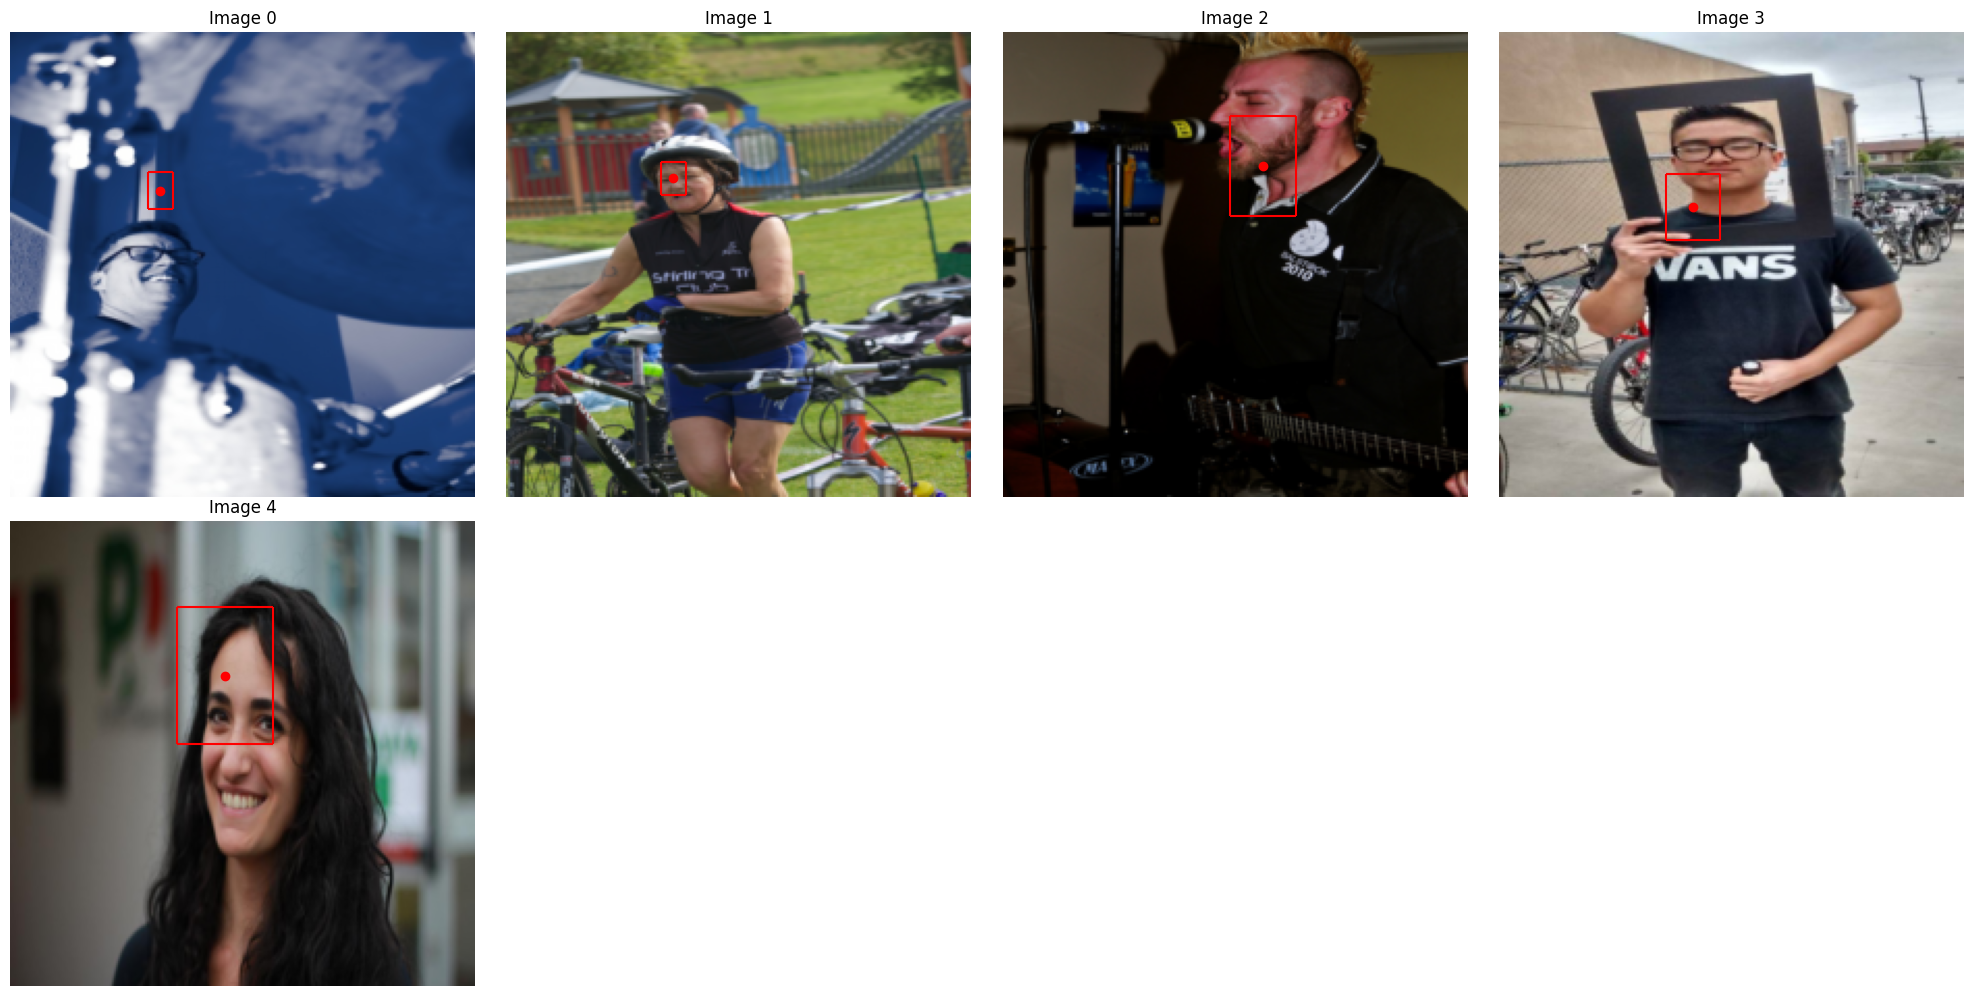

In [108]:
for epoch in range(100):
    #train
    logits = simp_conv(X)
    loss = criterion(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())
    

    #dev
    logits = simp_conv(X_dev)
    loss = criterion(logits, y_dev)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi_dev.append(loss.item())


    if epoch % 10 == 0:
        plt.plot(lossi, label='train')
        plt.plot(lossi_dev, label='dev')
        plt.legend()
        plt.savefig('loss.jpeg')
        plt.close()




plot_image_grid(X_dev, logits, epoch=epoch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0032678808..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03907385..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.021943567..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0016887592..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


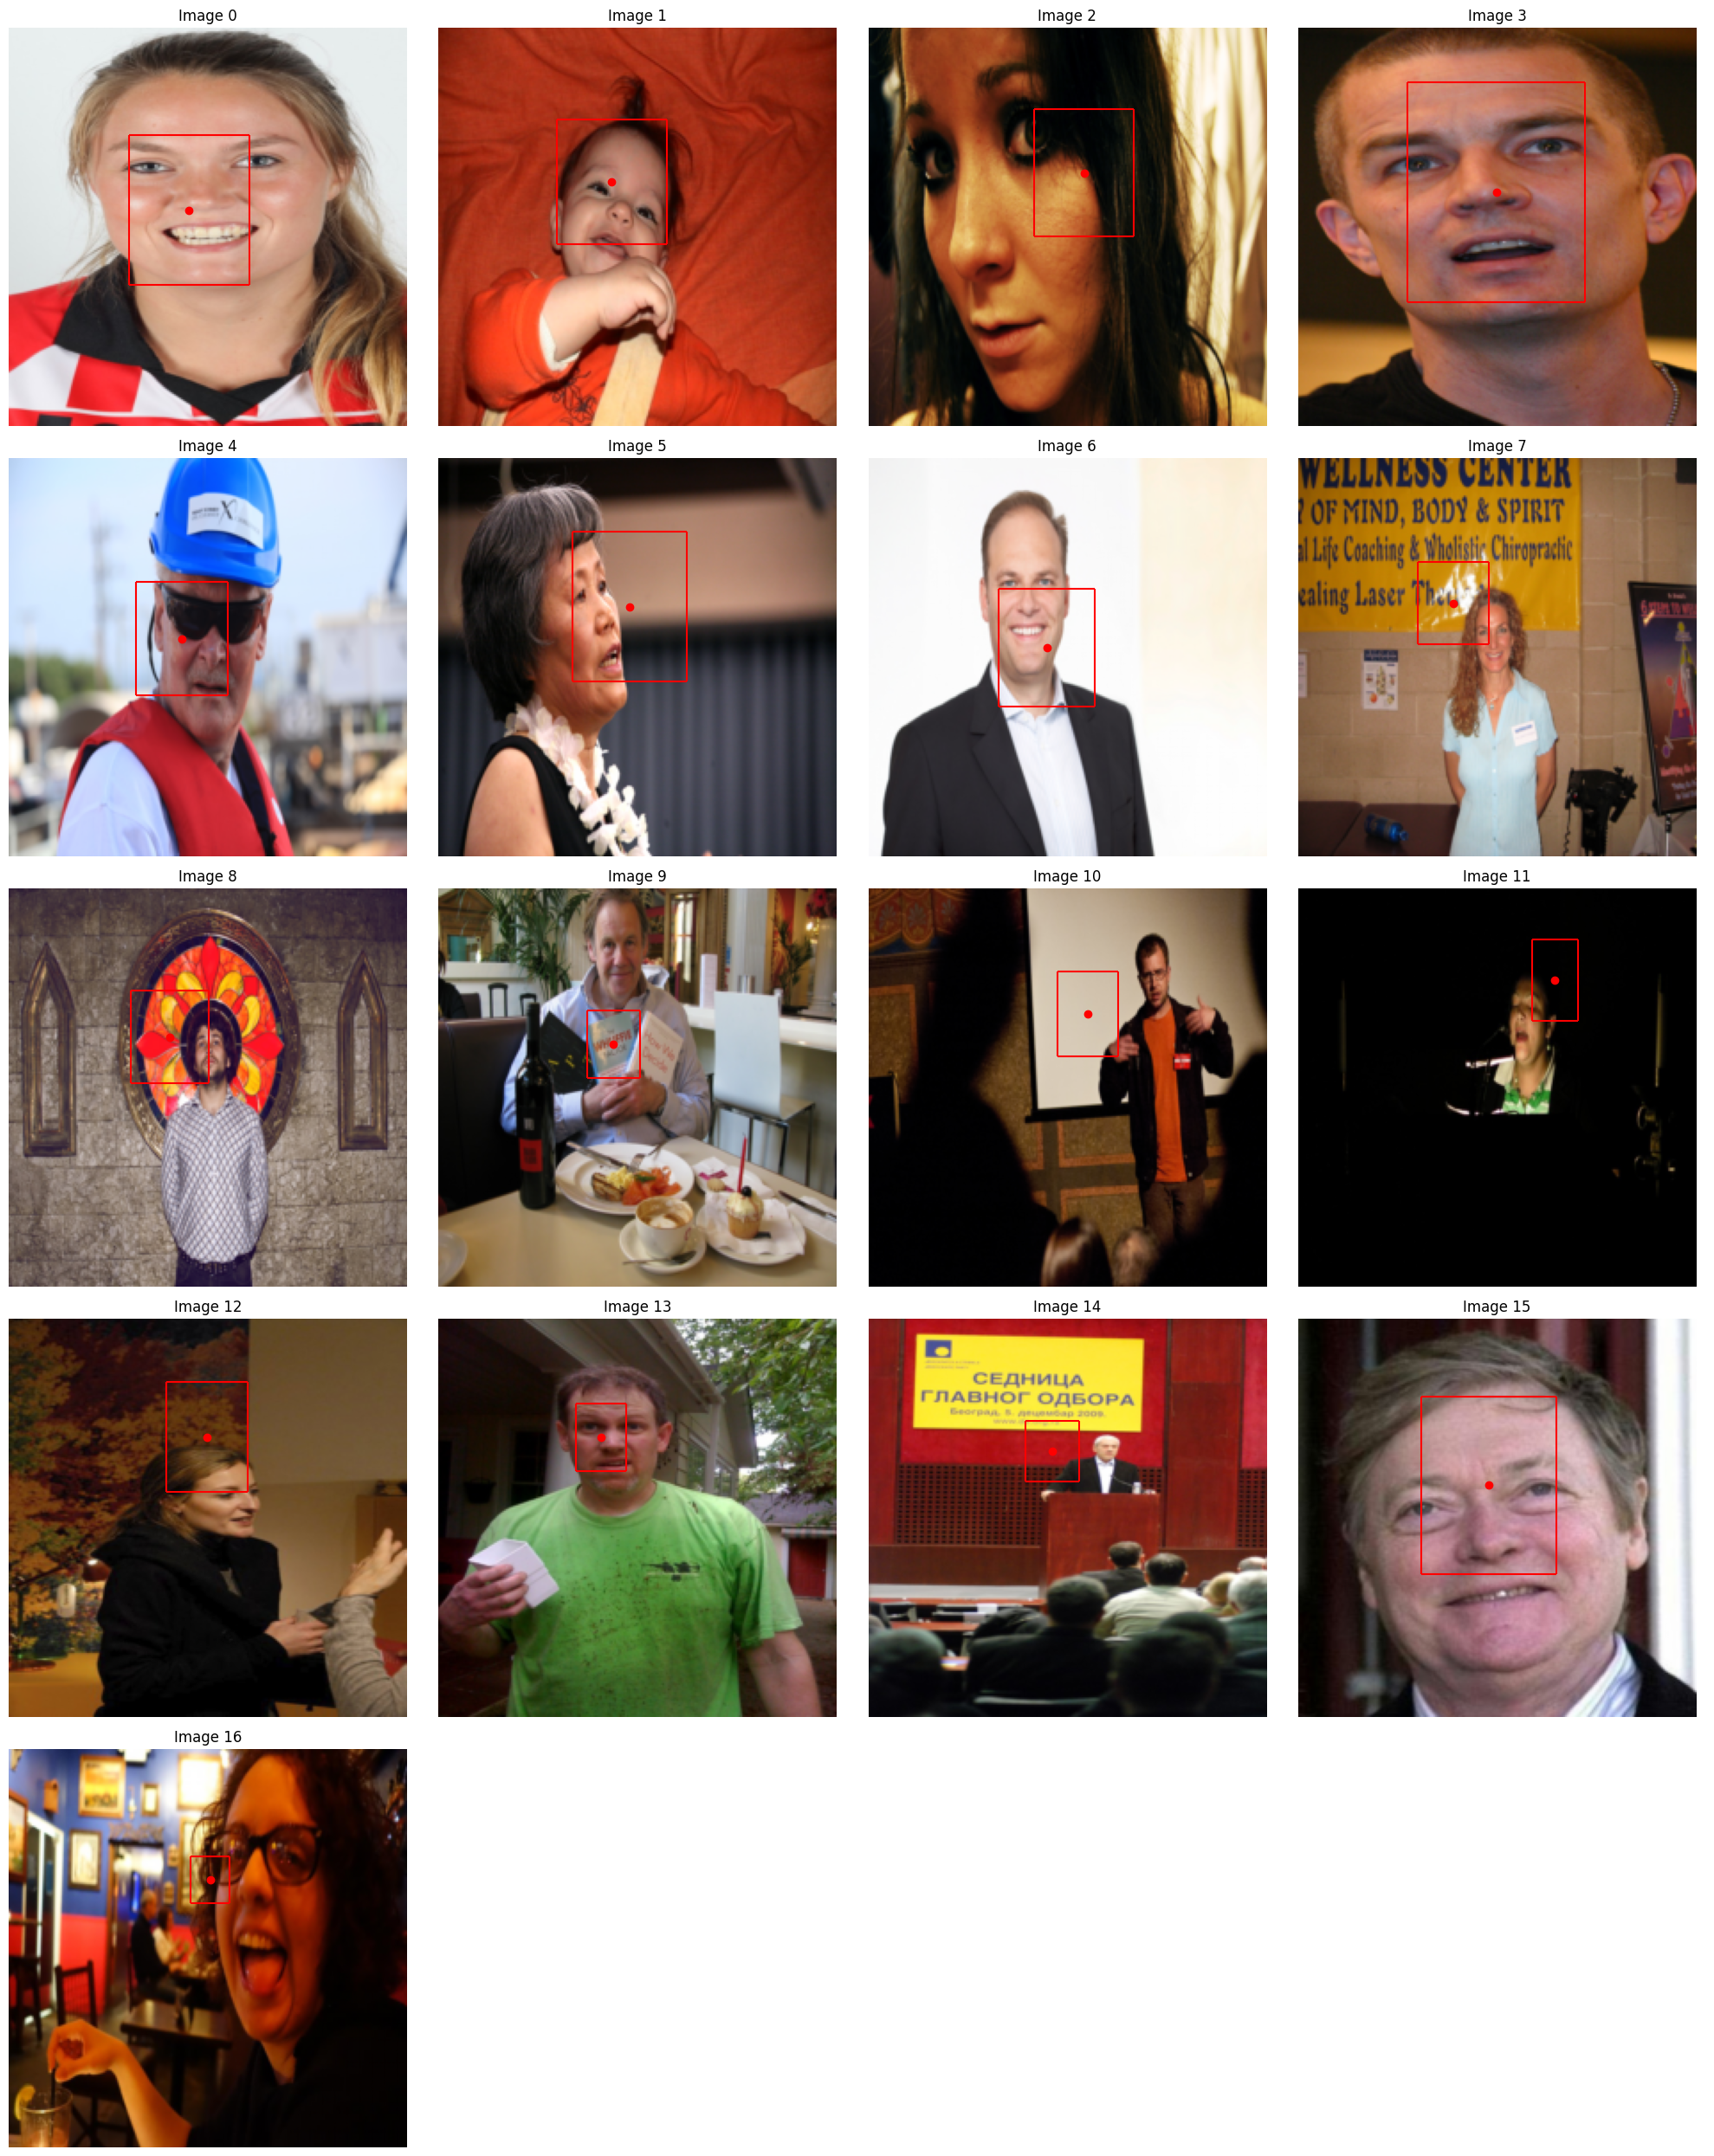

In [109]:
logits = simp_conv(X)
plot_image_grid(X, logits, epoch=epoch+1)